In [1]:
# Import the standard, publicly-available iris data set

import pandas as pd
from sklearn.datasets import load_iris

data = load_iris()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])

In [2]:
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


In [3]:
# The target in the iris dataset represents the species of iris
# 0: Iris setosa
# 1: Iris versicolor
# 2: Iris virginica 

print(y)

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64


In [4]:
# Split data into appropriate training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,
                                                        y,
                                                        train_size=0.7,
                                                        random_state=0)
X_train.shape, X_test.shape

((105, 4), (45, 4))

In [5]:
# Set and initialize the AutoMLx engine
import automlx
from automlx import init

init(engine='local')

In [8]:
# Train a model using AutoMLx
# Exclude LightGBM because it creates so many warnings on such a small data set.
# For reference here is the complete list of model's for classification
#model_list = [
#    "CatBoostClassifier", 
#    "DecisionTreeClassifier", 
#    "ExtraTreesClassifier", 
#    "GaussianNB", 
#    "KNeighborsClassifier", 
#    "LGBMClassifier", 
#    "LogisticRegression", 
#    "RandomForestClassifier", 
#    "SVC", 
#    "TorchMLPClassifier", 
#    "XGBClassifier"
#]

model_list = [
    "CatBoostClassifier", 
    "DecisionTreeClassifier", 
    "ExtraTreesClassifier", 
    "GaussianNB", 
    "KNeighborsClassifier", 
    "LogisticRegression", # <-- Notice that "LGBMClassifier" has been dropped from the list here..
    "RandomForestClassifier", 
    "SVC", 
    "TorchMLPClassifier", 
    "XGBClassifier"
]

est = automlx.Pipeline(model_list=model_list, task='classification')
est.fit(X_train, y_train)

[2025-11-25 18:59:32,116] [automlx.interface] Dataset shape: (105,4)
[2025-11-25 18:59:32,215] [automlx.data_transform] Running preprocessing. Number of features: 5
[2025-11-25 18:59:32,352] [automlx.data_transform] Preprocessing completed. Took 0.136 secs
[2025-11-25 18:59:32,364] [automlx.process] Running Model Generation
[2025-11-25 18:59:32,412] [automlx.process] Model Generation completed.
[2025-11-25 18:59:32,476] [automlx.model_selection] Running Model Selection
[2025-11-25 19:00:13,382] [automlx.model_selection] Model Selection completed - Took 40.906 sec - Selected models: [['ExtraTreesClassifier']]
[2025-11-25 19:00:13,447] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (105,5).
[2025-11-25 19:00:13,467] [automlx.adaptive_sampling] Adaptive Sampling: top_limit: 32 < bottom_limit: 1000,
sampling process will be skipped
[2025-11-25 19:00:13,473] [automlx.adaptive_sampling] Adaptive Sampling: top_limit: 8 < bottom_limit: 1000,
sampling process will be skip

In [9]:
# Use the F1_score scoreing metric to evaluate the model's performance
from sklearn.metrics import f1_score

y_pred = est.predict(X_test)
score_default = f1_score(y_test, y_pred, average='macro')
print(f'Score on test data : {score_default}')

Score on test data : 0.975983436853002


In [10]:
# Explain the generated classifier
explainer = automlx.MLExplainer(est,
                                   X_train,
                                   y_train,
                                   task="classification")

result_explain_model_default = explainer.explain_model()
result_explain_model_default.to_dataframe()

,Feature,Attribution,Lower Bound,Upper Bound
0,petal length (cm),0.474514,0.419046,0.529982
1,petal width (cm),0.245625,0.211734,0.279517
2,sepal width (cm),0.006741,-0.001061,0.014542
3,sepal length (cm),0.001925,-0.002067,0.005916


In [11]:
# Report the local explanation for a single dataset row

print("Explain the first row in our test data set...")
result_explain_prediction = explainer.explain_prediction(X=X_test.loc[X_test.index[0]])
print(result_explain_prediction)
      
print("Explain the second row in our test data set...")
result_explain_prediction = explainer.explain_prediction(X=X_test.loc[X_test.index[1]])
print(result_explain_prediction)

Explain the first row in our test data set...
[             Feature  Value  Attribution  Lower Bound  Upper Bound  Target
2  petal length (cm)    5.1         0.64    -0.050345     1.330345       2
0   petal width (cm)    2.4         0.48    -0.365496     1.325496       2
1   sepal width (cm)    2.8         0.08    -0.131374     0.291374       2
3  sepal length (cm)    5.8         0.04    -0.132586     0.212586       2]
Explain the second row in our test data set...
[             Feature  Value  Attribution  Lower Bound  Upper Bound  Target
2  petal length (cm)    4.0         0.56     0.137252     0.982748       1
0   petal width (cm)    1.0         0.52    -0.409405     1.449405       1
1   sepal width (cm)    2.2         0.00     0.000000     0.000000       1
3  sepal length (cm)    6.0         0.00     0.000000     0.000000       1]


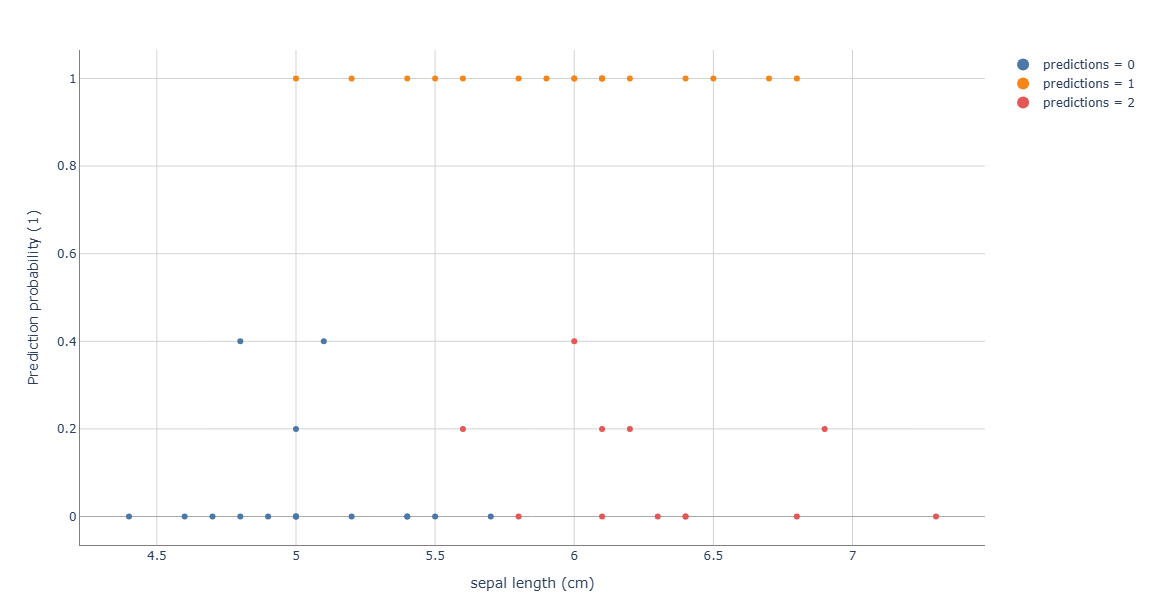

In [13]:
# Report the what if explaination for our test data set
result_explore_whatif = explainer.explore_whatif(X=X_test, y=y_test)